<a href="https://colab.research.google.com/github/swishswish123/endosim_demo/blob/main/notebooks/phantom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
!git clone https://github.com/swishswish123/endosim_demo.git

fatal: destination path 'endosim_demo' already exists and is not an empty directory.


In [102]:
!pip install scikit-surgeryvtk

# Phantom simulation

In this simulation we go directly from the patient coordinates to the MRI coordinates

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import nibabel as nib
import math
from statistics import mean 
from sksurgeryvtk.models.vtk_surface_model import VTKSurfaceModel
import PIL 
from matplotlib import pyplot as plt
import numpy as np

from sksurgeryvtk.models.vtk_surface_model import VTKSurfaceModel
from IPython.display import Image



## Utility functions and imports


In [104]:
%matplotlib inline

In [105]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    print(f'added {module_path} to sys')
    sys.path.append(module_path)

In [106]:
from endosim_demo.end_utils import create_transform, \
                                  multiply_points_by_matrix, \
                                  multiply_point_by_matrix, pointer_to_mri,\
                                  camera_to_mri, mri_to_camera, add_noise_to_points,\
                                  add_noise_to_params, extract_rigid_body_parameters,\
                                  rigid_body_parameters_to_matrix, \
                                  convert_4x1_to_1x1x3, project_camera_point_to_image, \
                                  create_pnt_ref, create_pnt_ref_in_camera_space, create_pat_ref, \
                                  create_pat_ref_in_camera_space, get_ref_T_tip, calculate_euclid_dist, convert_points_nx3_to_1xnx3


## Configurable parameters

note that you can change 

In [107]:
number_samples = 10000


In [108]:
def make_homogenous(matrix_NX3):
    matrix_NX4 = np.ones((matrix_NX3.shape[0],4))
    
    matrix_NX4[:,:3] = matrix_NX3
    return matrix_NX4
    
def dispNiftiSlice(image_data, nii_header, dim, slice_ind, int_lims=None):
    """
    function to display a slice of a 3D nifti image

    SYNTAX:
    dispNiftiSlice(image_data, nii_header, dim, slice_ind)
    dispNiftiSlice(image_data, nii_header, dim, slice_ind, int_lims)

    INPUTS:
    image_data - a 3D numpy array containing the image data to display, e.g.
       as returned by the getfdata function of a nibabel.nifti1.Nifti1Image object
    nii_header - a nibabel.nifti1.Nifti1Header object
    dim - the dimension that the slice is taken from ('x', 'y', or 'z')
    slice_ind - the slice index to display (zero-indexing first slice = 0)
    int_lims - a two element vector with the min and max intensities to display
       default = [np.nanmin(CT_1.get_fdata()) np.nanmax(CT_1.get_fdata())]   
    """

    # check if intensity limits have been provided, and if not set to min and
    # max of image
    if not int_lims:
        int_lims = [np.nanmin(image_data), np.nanmax(image_data)]
        # check if min and max are same (i.e. all values in img are equal)
        if int_lims[0] == int_lims[1]:
            # add one to int_lims(2) and subtract one from int_lims(1), so that
            # int_lims(2) is larger than int_lims(1) as required by imagesc
            # function
            int_lims[0] -= 1
            int_lims[1] += 1

    # set slice to display to selected slice
    if dim == 'x':
        slice_to_disp = np.squeeze(image_data[slice_ind, :, :]).T
    elif dim == 'y':
        slice_to_disp = np.squeeze(image_data[:, slice_ind, :]).T
    elif dim == 'z':
        slice_to_disp = np.squeeze(image_data[:, :, slice_ind]).T
    else:
        raise ValueError('dim must be x, y, or z')

    # clear any previous plot from current axes
    plt.gca().clear()

    # use imshow to display selected slice. if dim is x or y then the y-axis
    # should increase as it moves up the screen, if dim is z then the y-axis
    # increases as move down the screen
    if dim == 'z':
        plt.imshow(slice_to_disp, cmap='gray', vmin=int_lims[0], vmax=int_lims[1], origin='upper')
    else:
        plt.imshow(slice_to_disp, cmap='gray', vmin=int_lims[0], vmax=int_lims[1], origin='lower')

    # scale axis to account for voxel size
    pix_dim = nii_header.get_zooms()
    if dim == 'x':
        plt.gca().set_aspect(pix_dim[2] / pix_dim[1])
    elif dim == 'y':
        plt.gca().set_aspect(pix_dim[2] / pix_dim[0])
    elif dim == 'z':
        plt.gca().set_aspect(pix_dim[1] / pix_dim[0])


# Loading and investigating phantom CT scan

In [109]:
phantom = nib.load('endosim_demo/3D_images/transphenoidal_phantom.nii')
phantom_img = phantom.get_fdata()

In [110]:
phantom_img.shape

(512, 512, 192)

Looking at phantom slice along x, y and z planes:

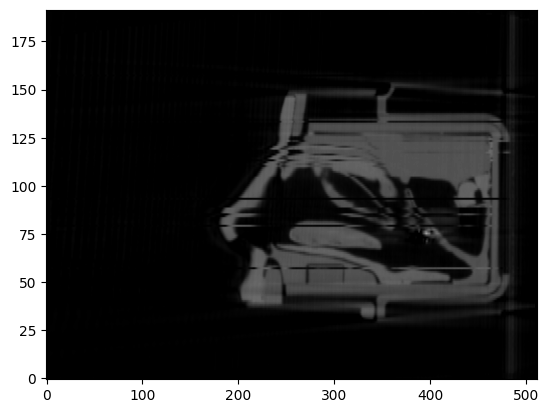

In [111]:
dispNiftiSlice(phantom_img, phantom.header, 'x', 300)

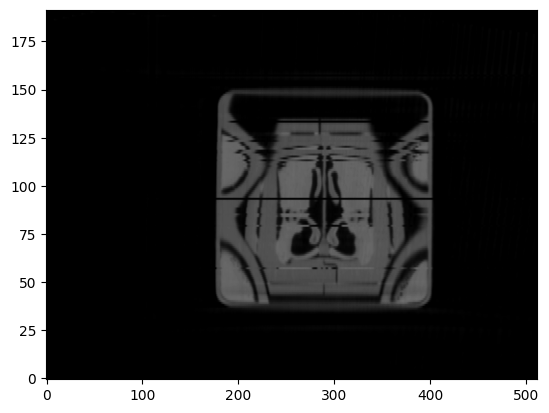

In [112]:
dispNiftiSlice(phantom_img, phantom.header, 'y', 300)

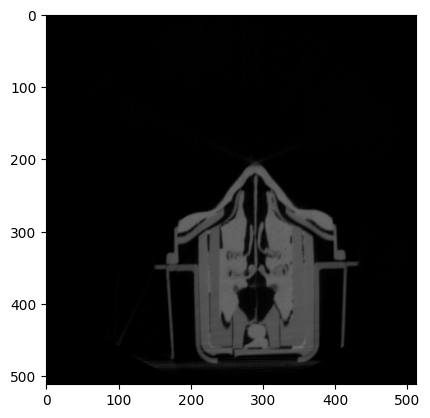

In [113]:
dispNiftiSlice(phantom_img, phantom.header, 'z', 100)

# VTK SURFACE

Using the CT scan of the phantom, the surface mesh is extracted using the NiftiMITK segmentation tool with a threshold value of -100 on a simple thresholding technique.

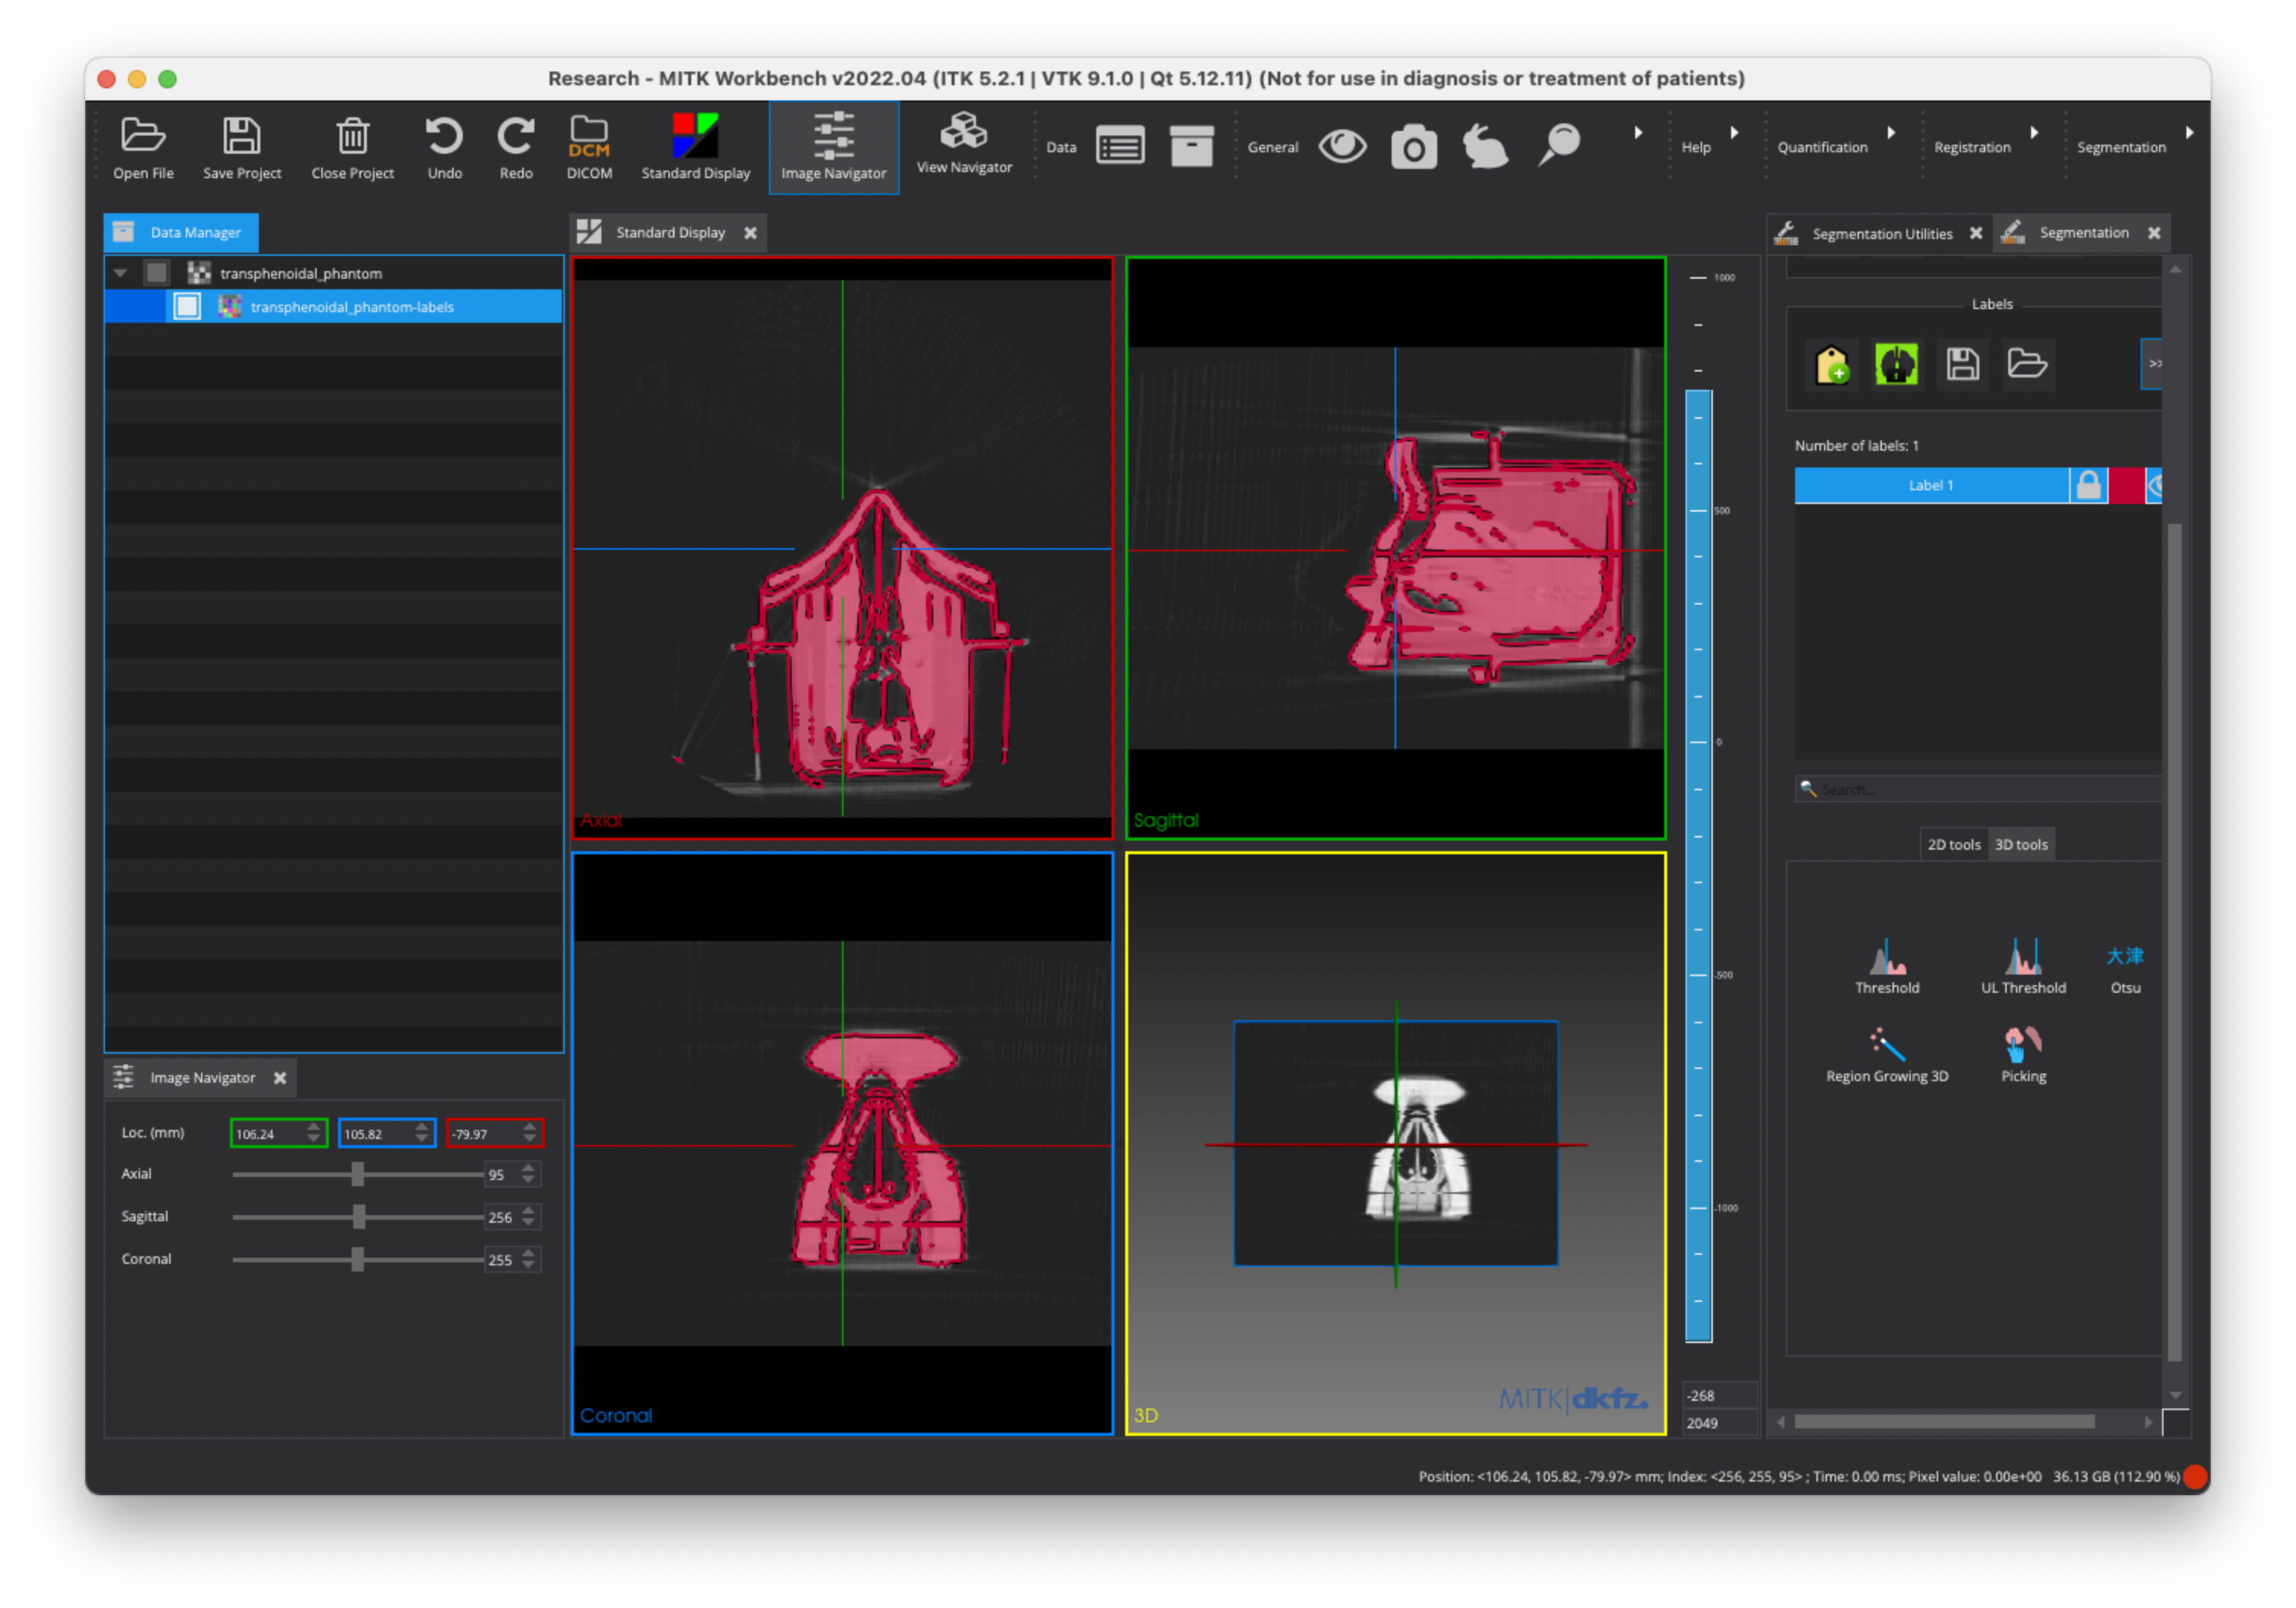

In [114]:

Image(filename='endosim_demo/images/segmentation_threshold.png')

In order to convert the segmentation to a surface (using NiftiMITK "create polygonal model" option), NiftiMITK performs a set of steps.
First, a vtkImageMedian3D filter with kernel size 3x3x3 is applied in order to remove small holes.
In order to ensure a consistent triangle size in the mesh, a vtkImageResample filter is then used to resample the volume to 1mm x 1mm x 1mm voxels.
The resultant binary image is rescaled using vtkImageShiftScale from a range of [0|1] to a range of [0|100].
% so that the next scale of 
Gaussian smoothing is applied to the rescaled segmentation using the vtkImageGaussianSmooth filter, where the Gaussian Standard Deviation was 1.5 and the Radius Factor was 0.49.
Once smoothed, the Marching Cubes algorithm \parencite[]{marching_cubes} is used using the vtkMarchingCubes filter with a threshold of 1 to create a triangle mesh.
The mesh is then smoothed using vtkSmoothPolyDataFilter, using 50 smoothing iterations, a relation of 0.1, feature angle of 60 degrees, feature edge smoothing OFF and boundary smoothing OFF.  
The mesh is then decimated using vtkQuadricDecimation filter in order to reduce the number of triangles of the mesh. The number triangles was reduced with a target reduction of 0.95. 
As the normals need to be used for the simulation, vtkPolyDataNormals is used to compute the normals, with FlipNormals ON.
Finally, vtkCleanPolyData is used to tidy up the mesh with PiceInvariant OFF, ConvertLinesToPoints OFF, ConvertPolysToLines OFF, ConvertStripsToPolys OFF and PointMerging ON. 

The resultant mesh can be seen below:

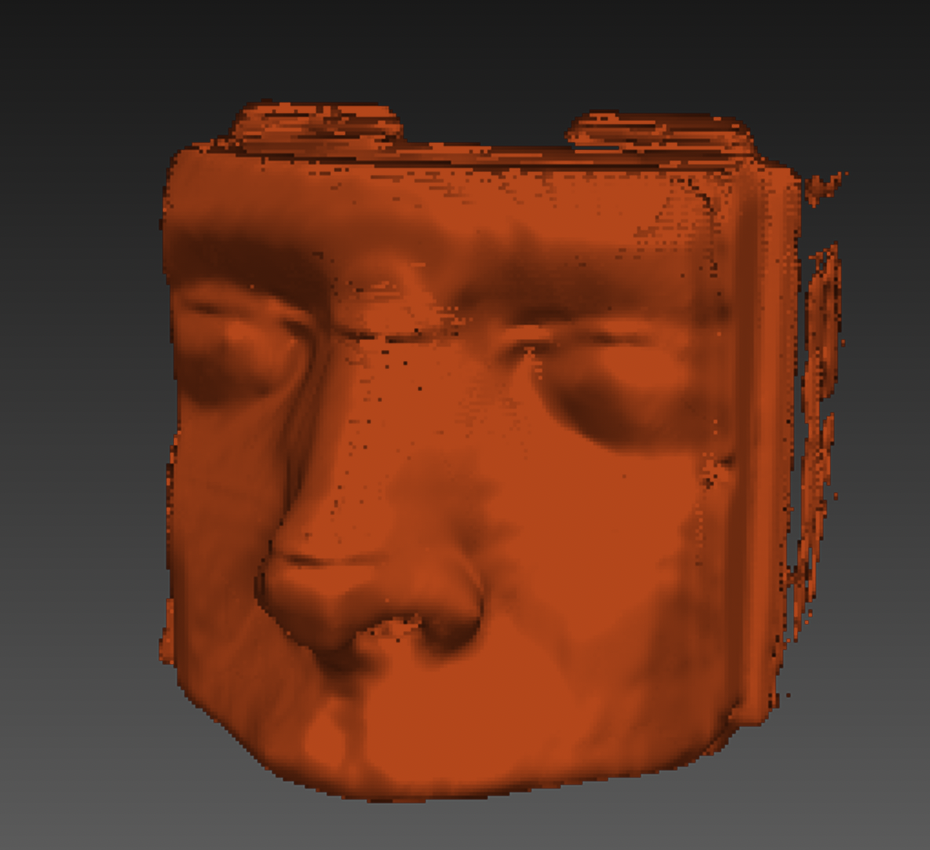

In [115]:
Image(filename="endosim_demo/images/vtk_mesh.png")

# Camera location

To simulate a realistic camera location in the sphenoid sinus, scikit-surgeryvtk was used to obtain the extrinsics matrix that will transform a point from the CT model to the endoscopic camera. In order to produce this initial model to camera transformation, we need a simple [VTK app](https://weisslab.cs.ucl.ac.uk/COMPASS/software/SmartLiver/-/blob/master/smartliver/apps/model2camera_app.py).

The vtk camera is placed and fixed at the origin of the camera space, towards the positive z-axis. The mesh is placed 500 mm in front of the camera to have sufficient space to see the entire mesh. 
We then move the model by scrolling and place the camera up the right nostrill until we arrive at the view we want to see. 

Below is an image showing the process of scrolling to the desired location:

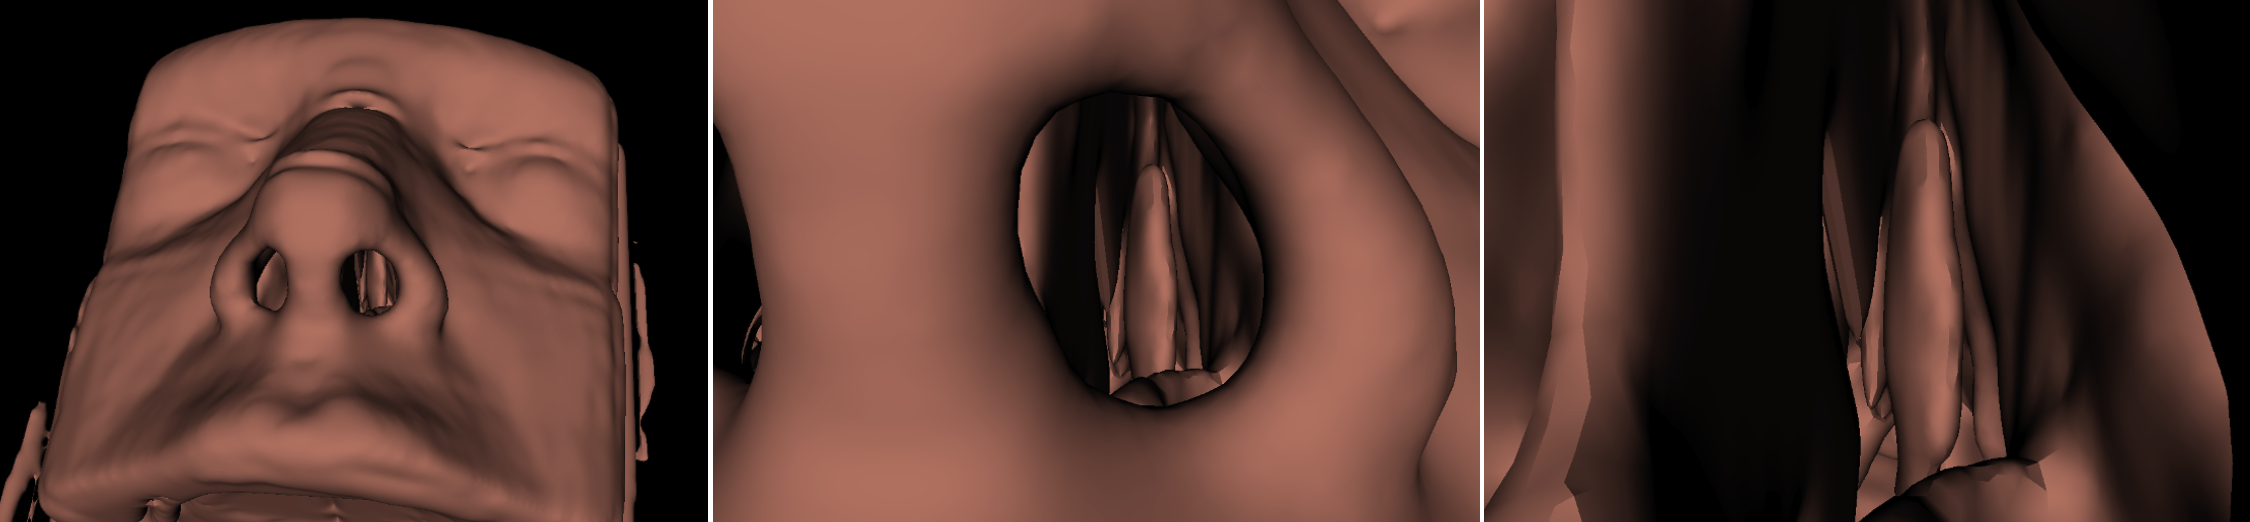

In [116]:
Image(filename="endosim_demo/images/scrolling_up_nostrill.png")

At this point when we have placed the mesh in the desired view, we can extract and save the model to camera matrix:

In [117]:
# transform to get from model to camera coords
T_model_cam = np.array([[0.996761, 0.049510, 0.063369, -122.931002],
                        [0.033279, 0.463408, -0.885520, -132.056007],
                        [-0.073207, 0.884761, 0.460259, -27.597528],
                        [0.000000, 0.000000, 0.000000, 1.000000]])

# Filtering points

We now want to filter out any points that shouldn't appear on the view of the endoscopic fideo. We would want to do the following:

- get rid of anything outside circle
- any values larger than 5cm away
- any normals facing away (dot product with 0,0,1) 
- 2.5cm either side

First we want to load the surface model and the corresponding normals, convert the surface points to homogenous coordinates, and then transform them from camera to model coordinates using the transformation obtained from the VTK app.

In [118]:
# load points and normals

filename = 'endosim_demo/3D_images/new_surface_consistent_normals.vtk'
model = VTKSurfaceModel(filename, (1.0, 1.0, 1.0), opacity=1.0)
points = model.get_points_as_numpy()
normals = model.get_normals_as_numpy()

print(points.shape, normals.shape)

# making points homogenous coordinates
points_hom = make_homogenous(points)

# converting points to camera coords with the transformation obtained from the vtk app
points_cam = multiply_points_by_matrix(T_model_cam, points_hom, do_transpose='False')


(237319, 3) (237319, 3)


we also want to convert the normals to the camera coordinate system:


In [119]:

T_rot = T_model_cam[:3,:3]

# convert normals to cam coords
normals_cam = normals @ T_rot

# normal representing the direction of the camera
cam_norm = np.array([0,0,1])

Visualising the conersion of the points to camera coords from model coords:

Text(0.5, 0.92, 'points in model coords')

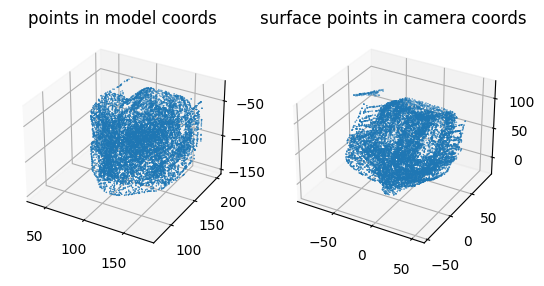

In [120]:
fig = plt.figure()
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(points_cam[::20,0], points_cam[::20,1], points_cam[::20,2], marker='*', s=0.000001)
ax.set_title('surface points in camera coords')

ax2 = fig.add_subplot(1,2,1, projection='3d')
ax2.scatter(points[::20,0], points[::20,1], points[::20,2], marker='*', s=0.000001)
ax2.set_title('points in model coords')


### Get rid of any points where normals facing away

Now that we have the surface points in the right coordinate system, we first want to filter out any points where the normals are facing away from the camera location as these surface points would not be visible to the camera.

We do this by only keeping the locations where the dot product between the z axis and the normals is smaller than zero as these points would be facing the camera.

In [121]:
# dot product to check what normals are facing the same direction or not
dot_prod = np.degrees(np.dot(normals_cam, cam_norm))
print('min', np.min(dot_prod))
print('max', np.max(dot_prod))

# taking only those facing the opoposite direction as camera
same_dir_idx = np.where(dot_prod<0)
print(same_dir_idx)

min -57.29133522054197
max 57.295451481200686
(array([     0,      1,      2, ..., 237312, 237317, 237318]),)


In [122]:
points_cam_norm_filtered = points_cam[same_dir_idx]

### Filter by distance

We also filter out points by distance to simulate the working range of an endoscopic camera. 

In [123]:
print('min', np.min(points_cam[:,0]),np.min(points_cam_norm_filtered[:,1]),np.min(points_cam_norm_filtered[:,2]))
print('max', np.max(points_cam[:,0]),np.max(points_cam_norm_filtered[:,1]),np.max(points_cam_norm_filtered[:,2]))


min -88.06348343818283 -44.122348264411926 -18.4323180025711
max 54.725597448486326 88.30576300175096 118.97643075348283


In [124]:
back_limit = 80
front_limit = 20
left_right_limit = 20
bottom_top_limit = 25

min -19.999529310955054 -24.991834538696295 20.003503411056524
max 19.994617767570503 24.99862083742522 79.98592179229738


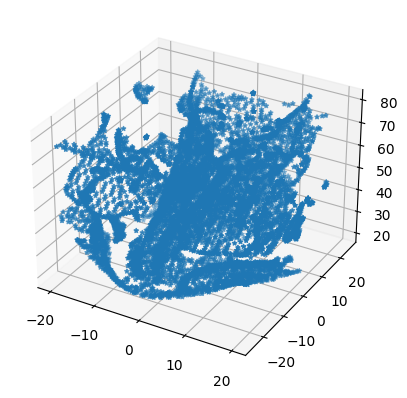

In [125]:
# in z
filtered_points = points_cam_norm_filtered[points_cam_norm_filtered[:,2]<back_limit] # back
filtered_points = filtered_points[filtered_points[:,2]>front_limit] # front

# in x
filtered_points = filtered_points[filtered_points[:,0]<=left_right_limit] # left
filtered_points = filtered_points[filtered_points[:,0]>=-left_right_limit] # right

# in y 
filtered_points = filtered_points[filtered_points[:,1]<=bottom_top_limit] # bottom
filtered_points = filtered_points[filtered_points[:,1]>-bottom_top_limit] # top

# sanity check values are within specified range
print('min', np.min(filtered_points[:,0]),np.min(filtered_points[:,1]),np.min(filtered_points[:,2]))
print('max', np.max(filtered_points[:,0]),np.max(filtered_points[:,1]),np.max(filtered_points[:,2]))

# visualising results
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(filtered_points[::2,0], filtered_points[::2,1], filtered_points[::2,2], marker='*', s=10)
plt.show()

In [126]:
#np.savetxt('points_cam.txt',points_cam[:,:3])
#np.savetxt('filtered_points.txt',filtered_points[:,:3])

### project points from 3D to 2D

Now we want to project the 3D points onto 2D. To do this, we use the intrinsics and extrinsics matrix we obtained by calibrating the storz endoscope we are using for the purpose of the simulation. 

In [127]:
intrinsics = np.loadtxt('endosim_demo/calibration/intrinsics.txt')
distortion = np.loadtxt('endosim_demo/calibration/distortion.txt')

In [128]:
print('intrinsics', intrinsics)
print('distortion', distortion)

intrinsics [[664.6329766    0.         931.53151205]
 [  0.         663.83211807 520.64004697]
 [  0.           0.           1.        ]]
distortion [-4.0929449e-01  2.1631278e-01  1.1120000e-05  1.2712000e-03
 -7.2057120e-02]


In [129]:
# projecting the filtered points using the intrinsics and distortion matrices obtained during calibration

rvec = np.zeros((1,3))
tvec = np.zeros((1,3))

points2D, jacobian = cv2.projectPoints(np.array(filtered_points[:,:3],dtype='float64') , rvec, tvec, intrinsics, distortion)

# as there are some extta dimensions in this output, we use np.squeeze to get rid of that:
points2D = np.squeeze(points2D)
points2D


array([[ 799.92369965,  988.80854663],
       [ 728.75719182,  982.31985749],
       [ 734.99340147,  983.42154853],
       ...,
       [ 520.97062201,  488.13787888],
       [ 920.80319553,  517.92770538],
       [1117.10852888,  396.60966273]])

# Filter out anything outside endoscopic view

Once projected, the points that lie outside the circular endoscopic view are filtered out.

mean 926.3217567954688
min 458.07690005240346
max 1406.4792379416026


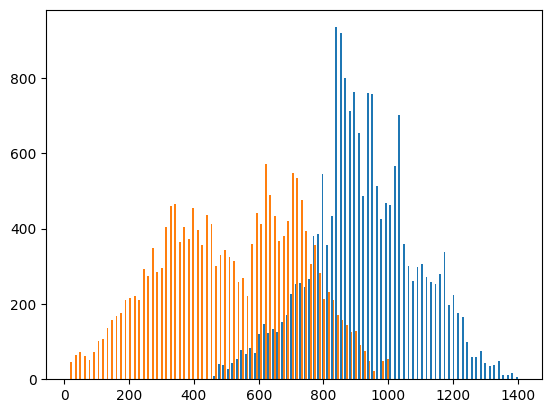

In [130]:
print('mean', np.mean(points2D[:,0]))
print('min', np.min(points2D[:,0]))
print('max', np.max(points2D[:,0]))

plt.hist(points2D, bins=100)

plt.show()

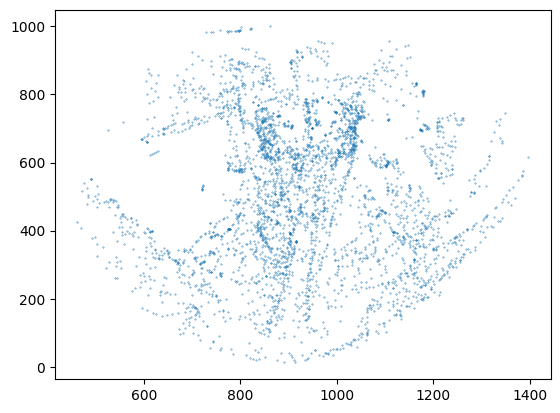

In [131]:
fig, ax = plt.subplots()
ax.scatter(points2D[::5,0], points2D[::5,1], s=0.1)
plt.show()

In order to only take out things from inside the endoscopic view, we use a random frame obtained using the storz endoscope and manually find the centre of the circle and the radius.

The image that can be seen in this case is in fact that of the phantom, where the simulated tumour can be seen as a brown cirle.

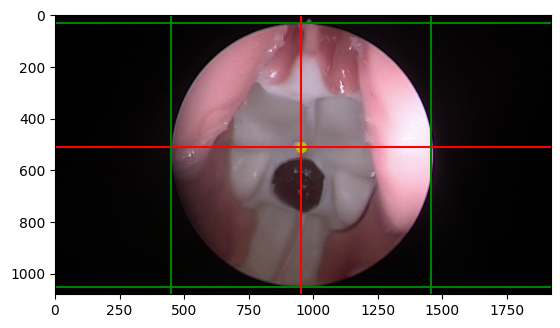

In [132]:
# STORZ ENDOSCOPE!

# load endoscope image and convert to np array
endoscope_image = 'endosim_demo/images/phantom_img.jpg'
image = PIL.Image.open(endoscope_image)
image = np.array(image)

plt.imshow(image)


# finding mid y position
low_y = 30
high_y = 1050
plt.axhline(y=low_y, color='g', linestyle='-')
plt.axhline(y=high_y, color='g', linestyle='-')

mid_y = (high_y-low_y)/2
plt.axhline(y=mid_y, color='r', linestyle='-')

low_x = 450
high_x = 1455
plt.axvline(x=low_x, color='g', linestyle='-')
plt.axvline(x=high_x, color='g', linestyle='-')

mid_x = (high_x-low_x)/2 +low_x
plt.axvline(x=mid_x, color='r', linestyle='-')

centre = [mid_x,mid_y]
plt.scatter(mid_x,mid_y, color='y', s=50)

radius = mid_x-low_x # could also be mid_y-low_y, or negative of mid_x-high_x or -ve of mid_y-high_y

Using the calculated middle point coordinates and the radius, we want to only keep the points where the distance between the middle of the circle and that coordinate is smaller than the radius:

In [133]:
d = (points2D[:,0]-mid_x)**2 + (points2D[:,1]-mid_y)**2
res = d < radius**2

# lying within radius
filtered_points2D_within_end = points2D[res]
filtered_points2D_within_end

array([[ 867.33782571, 1000.20456151],
       [ 796.73796792,  987.51111127],
       [ 815.85524691,  990.6181098 ],
       ...,
       [ 520.97062201,  488.13787888],
       [ 920.80319553,  517.92770538],
       [1117.10852888,  396.60966273]])

Visualising the result:

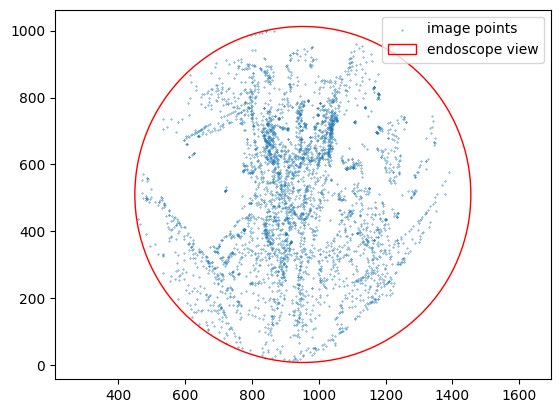

In [134]:
fig, ax = plt.subplots()

ax.scatter(filtered_points2D_within_end[::5,0], filtered_points2D_within_end[::5,1], s=0.1)

circle = plt.Circle((mid_x, mid_y), radius, color='r', fill=False)
ax.add_patch(circle)

ax.axis('equal')
plt.legend(['image points', 'endoscope view'])


We can also visualise the points on top of an endoscopic video. Of course the views are not going to be the same as the points were obtained directly from the CT scan and the video using an endoscope through the phantom nose. However, you can get the general idea as you can for example see the more concentrated points lying on top of the tumour. 

# tumour surface

In order to simulate the effects of noise on an AR view, we use the phantom's tumour to visualise and calculate the errors. 

The tumour is first segmented from the phantom's CT scan using niftiMITK by manually selecting the corresponding pixels at every slice that belong to the tumour. 

This can be seen in the figure below: 


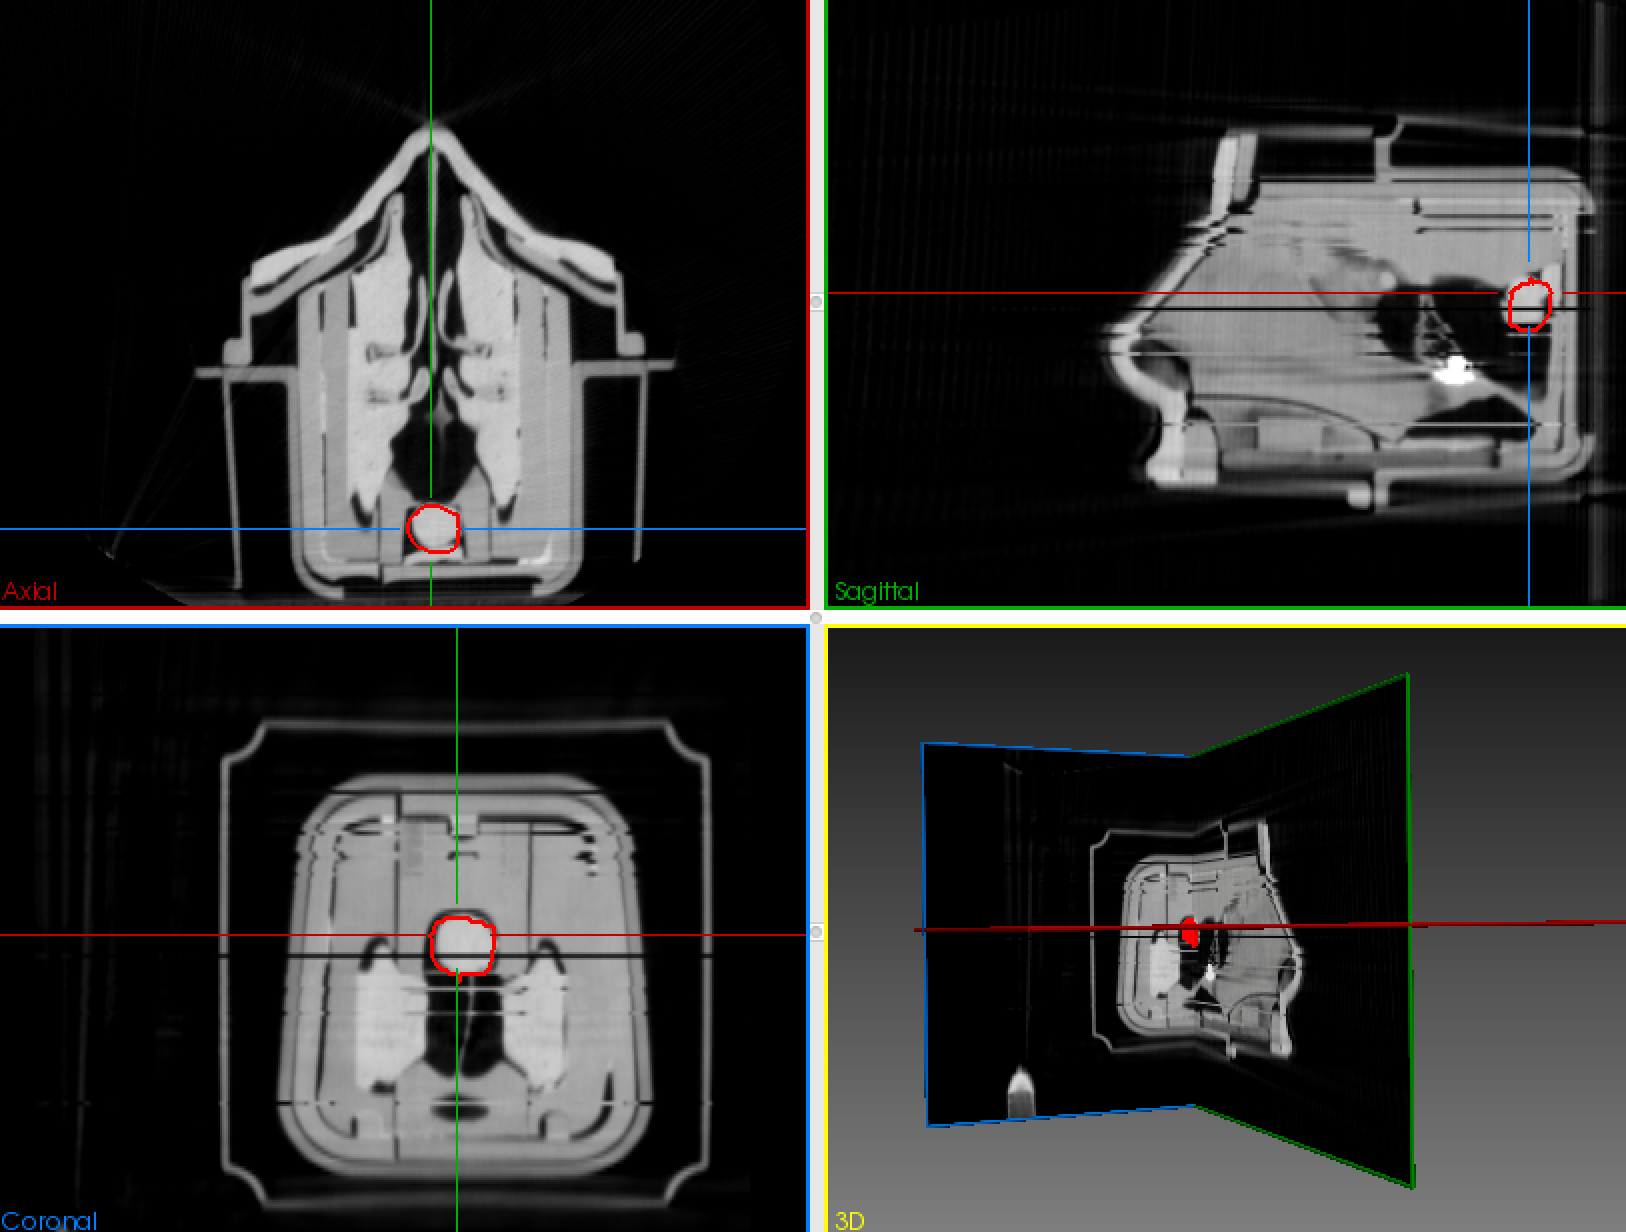

In [136]:
Image(filename="endosim_demo/images/tumor_mitk.png")

A mesh of the tumour is then generated using the same method for obtaining the phantom's surface mesh. 


In [137]:
# loading tumour points and normals 
tumour_filename = 'endosim_demo/3D_images/tumour.vtk'
tumour_model = VTKSurfaceModel(tumour_filename, (1.0, 1.0, 1.0), opacity=1.0)
tumour_points = tumour_model.get_points_as_numpy()
tumour_normals = tumour_model.get_normals_as_numpy()

# converting points to camera coords
tumour_points_hom = make_homogenous(tumour_points)
# converting to camera coordinate system
tumour_points_cam = multiply_points_by_matrix(T_model_cam, tumour_points_hom, do_transpose='False')
print(tumour_points_cam)

[[-1.26266494 29.62062576 81.19922063  1.        ]
 [-1.24656997 29.15541074 81.2068831   1.        ]
 [-1.44359797 29.24488118 81.40614737  1.        ]
 ...
 [ 4.04720943 21.03363692 92.90451218  1.        ]
 [ 2.41313644 21.17070512 93.39320538  1.        ]
 [ 2.43368352 21.3630234  93.76038876  1.        ]]


Visualising tumour surface:

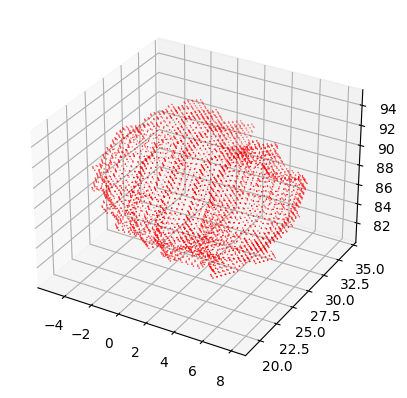

In [138]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(tumour_points_cam[::1,0], tumour_points_cam[::1,1], tumour_points_cam[::1,2], c='r', marker='*', s=0.000001)
plt.show()

And as we did with the surface points, we project the tumour points to obtain the endoscopic view:

In [139]:
tumour_points2D, jacobian = cv2.projectPoints(np.array(tumour_points_cam[:,:3],dtype='float64') , rvec, tvec, intrinsics, distortion)
tumour_points2D = np.squeeze(tumour_points2D)

Visualising the tumour along with the image points obtained previously:

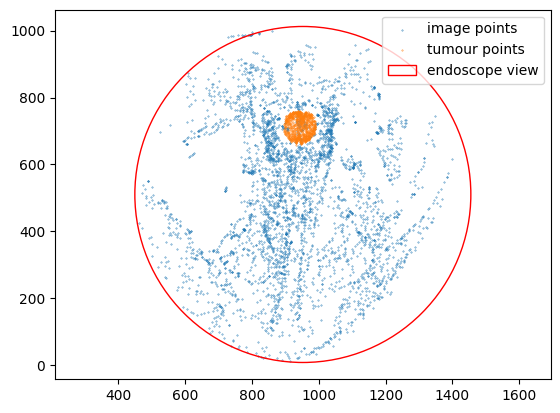

In [140]:
fig, ax = plt.subplots()
# img points
ax.scatter(points2D[::5,0], points2D[::5,1], s=0.1)
# tumour
ax.scatter(tumour_points2D[::5,0], tumour_points2D[::5,1], s=0.1)
# endoscopic view
circle = plt.Circle((mid_x, mid_y), radius, color='r', fill=False)
ax.add_patch(circle)

ax.axis('equal')
plt.legend(['image points','tumour points', 'endoscope view'])

### ADDING NOISE TO tumour

In order to simulate added noise to the tumour, we add Gaussian noise to the parameters of the extrinsics matrix (T_parameters below) transformation and project the 3D points with this matrix. 
We do this with different standard deviations to see the resulting visual effect on the AR display.

In [141]:
T_parameters = extract_rigid_body_parameters(T_model_cam)

[[-1.38124488 29.15201644 81.89531396  1.        ]
 [-1.36465586 28.68679093 81.90103945  1.        ]
 [-1.56182412 28.77521938 82.10063006  1.        ]
 ...
 [ 3.93513821 20.52192494 93.56590311  1.        ]
 [ 2.30080932 20.65521306 94.05478921  1.        ]
 [ 2.32106858 20.84601947 94.4227764   1.        ]]
error in sigma 0.12: [ 2.19646045 75.58134748]


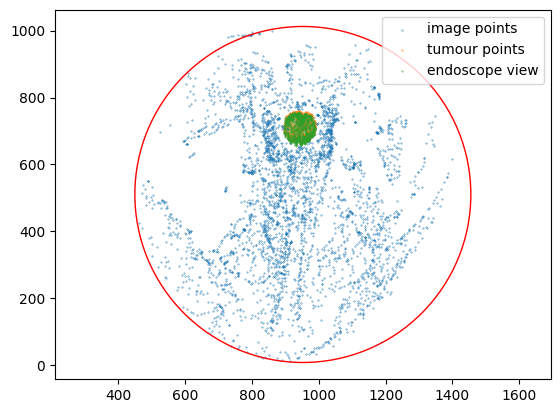

In [142]:
sigma = 0.12



T_parameters_noisy = add_noise_to_params(T_parameters, sigma)
T_model_cam_noisy = rigid_body_parameters_to_matrix(T_parameters_noisy)



# transforming tumour with noisy transform

# converting points to camera coords
# tumour_points_hom_noisy = make_homogenous(tumour_points_noisy)

tumour_points_cam_noisy = multiply_points_by_matrix(T_model_cam_noisy, tumour_points_hom, do_transpose='False')
print(tumour_points_cam_noisy)



# project tumour

tumour_points2D_noisy, jacobian = cv2.projectPoints(np.array(tumour_points_cam_noisy[:,:3],dtype='float64') , rvec, tvec, intrinsics, distortion)
tumour_points2D_noisy = np.squeeze(tumour_points2D_noisy)

euclid_dist =  calculate_euclid_dist(tumour_points2D, tumour_points2D_noisy)
print(f'error in sigma {sigma}: {euclid_dist}')

# PLOT
fig, ax = plt.subplots()
ax.scatter(points2D[::5,0], points2D[::5,1], s=0.1)
ax.scatter(tumour_points2D[::5,0], tumour_points2D[::5,1], s=0.1)
ax.scatter(tumour_points2D_noisy[::5,0], tumour_points2D_noisy[::5,1], s=0.1)

circle = plt.Circle((mid_x, mid_y), radius, color='r', fill=False)

ax.add_patch(circle)
ax.axis('equal')
plt.legend(['image points','tumour points', 'endoscope view'])

### Pseudo code

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 1, in steps of 0.01
*   for iteration in 1 to 1000.
*     add zero mean Gaussian(sigma) noise to transformation parameters of model to cam transform
*     Transform tumour using the noisy model to cam transform
*     measure average Euclidean distance between all noisy and regular tumour points
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma
```

error in sigma 0.12: 4.389632618782613
error in sigma 0.25: 9.112240987141456
error in sigma 0.5: 18.416201287763258


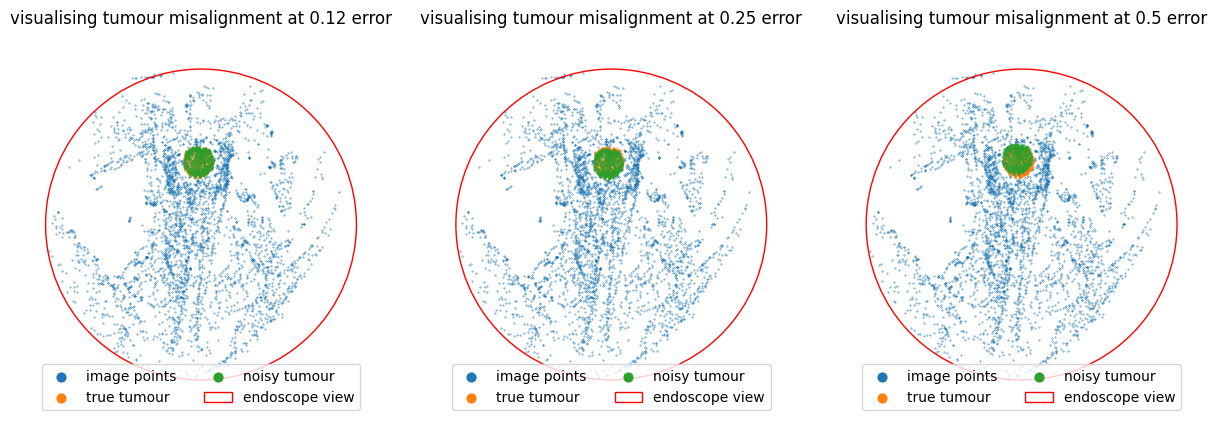

In [163]:

x_values = []
y_values = []
n=0
num_subplots = 3

fig, ax = plt.subplots(1, num_subplots, figsize=(5*num_subplots,5), subplot_kw=dict(xticks=[],yticks=[]))

for sigma_counter in range(0, 100, 1):
#for sigma in [0.12, 0.25, 0.5]:

    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        
        # adding noise to transform parameters
        T_parameters_noisy = add_noise_to_params(T_parameters, sigma)
        T_model_cam_noisy = rigid_body_parameters_to_matrix(T_parameters_noisy)

        # transforming tumour with noisy transform
        tumour_points_cam_noisy = multiply_points_by_matrix(T_model_cam_noisy, tumour_points_hom, do_transpose='False')

        # project tumour
        tumour_points2D_noisy, jacobian = cv2.projectPoints(np.array(tumour_points_cam_noisy[:,:3],dtype='float64') , rvec, tvec, intrinsics, distortion)
        tumour_points2D_noisy = np.squeeze(tumour_points2D_noisy)

        # average of euclidean distance of all points in the tumour
        distances = []
        for idx, tumour in enumerate(tumour_points2D):
            tumour_noisy = tumour_points2D_noisy[idx]

            dist =  (tumour[0] - tumour_noisy[0]) \
                             * (tumour[0] - tumour_noisy[0]) \
                             + (tumour[1] - tumour_noisy[1]) \
                             * (tumour[1] - tumour_noisy[1]) 

            distances.append(dist)

        euclid_dist = mean(distances)
        
        # RMS
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    
    if sigma == 0.12 or sigma == 0.25 or sigma == 0.5 :

        print(f'error in sigma {sigma}: {rms}')

        # PLOT
        #fig, ax = plt.subplots(4,1)
        
        #n=0
        ax[n].scatter(points2D[::5,0], points2D[::5,1], s=0.1, label='image points')
        ax[n].scatter(tumour_points2D[::5,0], tumour_points2D[::5,1], s=0.1, label='true tumour')
        ax[n].scatter(tumour_points2D_noisy[::5,0], tumour_points2D_noisy[::5,1], s=0.1, label='noisy tumour')
        ax[n].set_title(f'visualising tumour misalignment at {sigma} error')
        circle = plt.Circle((mid_x, mid_y), radius, color='r', fill=False , label= 'endoscope view')
    
        ax[n].add_patch(circle)
        ax[n].axis('equal')
        # remove ticks 
        #ax[n].tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        ax[n].axis('off')
        ax[n].legend(loc='lower center', ncol=2, markerscale=20)
        
        n += 1

    x_values.append(sigma)
    y_values.append(rms)

#plt.tight_layout()
fig.savefig('results/AR_phantom_errors.pdf', bbox_inches='tight', dpi=150)
plt.show()
     

Plotting sigma effect on error

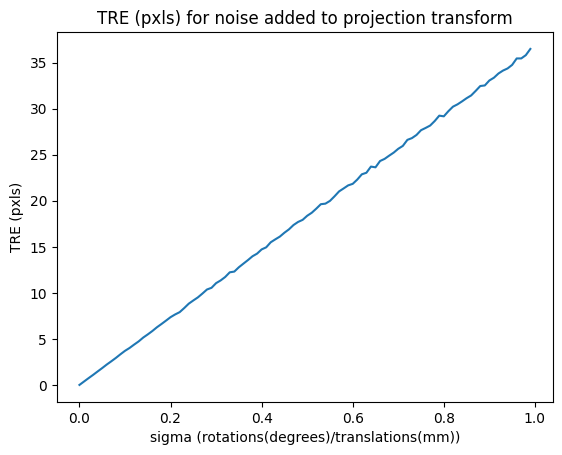

In [153]:
plt.figure()    
plt.plot(x_values, y_values)
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('TRE (pxls)')
plt.title('TRE (pxls) for noise added to projection transform')
plt.savefig('results_phantom.pdf')
plt.show()

In [150]:
x_values, y_values = np.array(x_values) , np.array(y_values)

In [151]:
print(f'error at sima 0.12: {y_values[x_values==0.12]}')
print(f'error at sima 0.15: {y_values[x_values==0.15]}')
print(f'error at sima 0.25: {y_values[x_values==0.25]}')

error at sima 0.12: [4.37864052]
error at sima 0.15: [5.48662533]
error at sima 0.25: [9.17324795]
